# Physics Informed Extreme Learning Machine : Falkner Skan BL Formulation A

**Name: Harish Wathore
<br>
Roll Number: 20101017
<br>**

Epoch 0, PDE Loss: 1.052776575088501, BC Loss: 0.035746876150369644, Total Loss: 1.088523507118225
Epoch 1000, PDE Loss: 0.011459517292678356, BC Loss: 0.0006797595997340977, Total Loss: 0.01213927660137415
Epoch 2000, PDE Loss: 0.0053304280154407024, BC Loss: 0.00015393206558655947, Total Loss: 0.00548436027020216


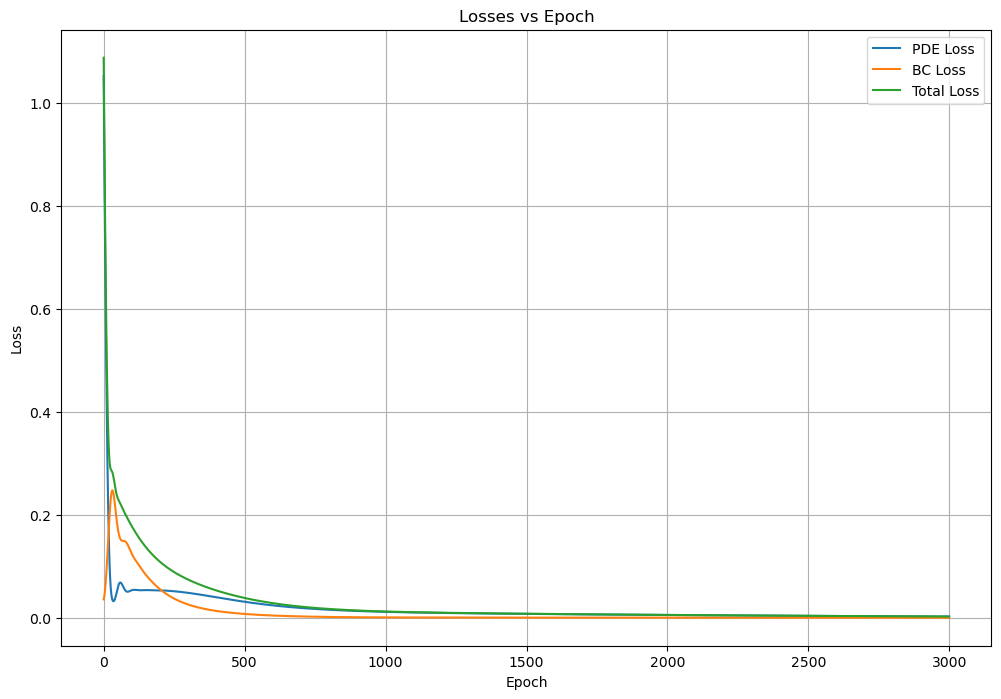

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# Define constants
beta = 1
m = beta / (2 - beta)

# Create the neural network model
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.dense1 = nn.Linear(1, 50)
        self.activation = torch.tanh
        self.dense2 = nn.Linear(50, 1)

        # Make the weights and biases untrainable in the input layer
        for param in self.dense1.parameters():
            param.requires_grad = False
        
    def forward(self, eta):
        eta = self.dense1(eta)
        eta = self.activation(eta)
        eta = self.dense2(eta)
        return eta

    # Define the PDE
    def pde(self, x):
        eta = x
        f = self(eta)
        f1 = torch.autograd.grad(f, eta, create_graph=True, grad_outputs=torch.ones_like(f))[0]
        f2 = torch.autograd.grad(f1, eta, create_graph=True, grad_outputs=torch.ones_like(f1))[0]
        f3 = torch.autograd.grad(f2, eta, create_graph=True, grad_outputs=torch.ones_like(f2))[0]
        ode = f3 + f2 * f + beta * (1 - f1**2)
        pde_loss = F.mse_loss(ode, f)

        bc_1 = F.mse_loss(f[0], torch.zeros_like(f[0]))
        bc_2 = F.mse_loss(f1[0], torch.zeros_like(f1[0]))
        bc_3 = F.mse_loss(f1[-1], torch.zeros_like(f1[0]))

        loss = pde_loss + bc_1 + bc_2 + bc_3
        bc_t = bc_1 + bc_2 + bc_3
        return pde_loss, bc_t, loss

# Create the neural network model
model = NeuralNet()
models = []

# Function to train the neural network and record output weights
def train_neural_net(model, num_iterations=3000, learning_rate=0.001):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    x_pde = torch.linspace(0, 5, 1000).view(-1, 1).requires_grad_()

    pde_losses = []  # List to store PDE losses
    bct_losses = []  # List to store BC losses
    total_losses = []  # List to store total losses
    models = []
    output_weights = []  # List to store output layer weights

    for epoch in range(num_iterations):
        optimizer.zero_grad()
        pde_loss, bc_t, loss = model.pde(x_pde)
        loss.backward()
        optimizer.step()

        pde_losses.append(pde_loss.item())
        bct_losses.append(bc_t.item())
        total_losses.append(loss.item())

        # Record the weights of the output layer
        output_weights.append(model.dense2.weight.data.clone().cpu().numpy())

        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, PDE Loss: {pde_loss.item()}, BC Loss: {bc_t.item()}, Total Loss: {loss.item()}")

    return pde_losses, bct_losses, total_losses, output_weights

pde_losses, bct_losses, total_losses, output_weights = train_neural_net(model)
models.append(model)

# Save the trained model
torch.save(model.state_dict(), 'neural_net_model_pytorch.pth')

# Plot the losses against epoch
plt.figure(figsize=(12, 8))
plt.grid()
epochs = range(len(pde_losses))
plt.plot(epochs, pde_losses, label="PDE Loss")
plt.plot(epochs, bct_losses, label="BC Loss")
plt.plot(epochs, total_losses, label="Total Loss")
plt.title("Losses vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()




# Output Weights Convergence With Epochs

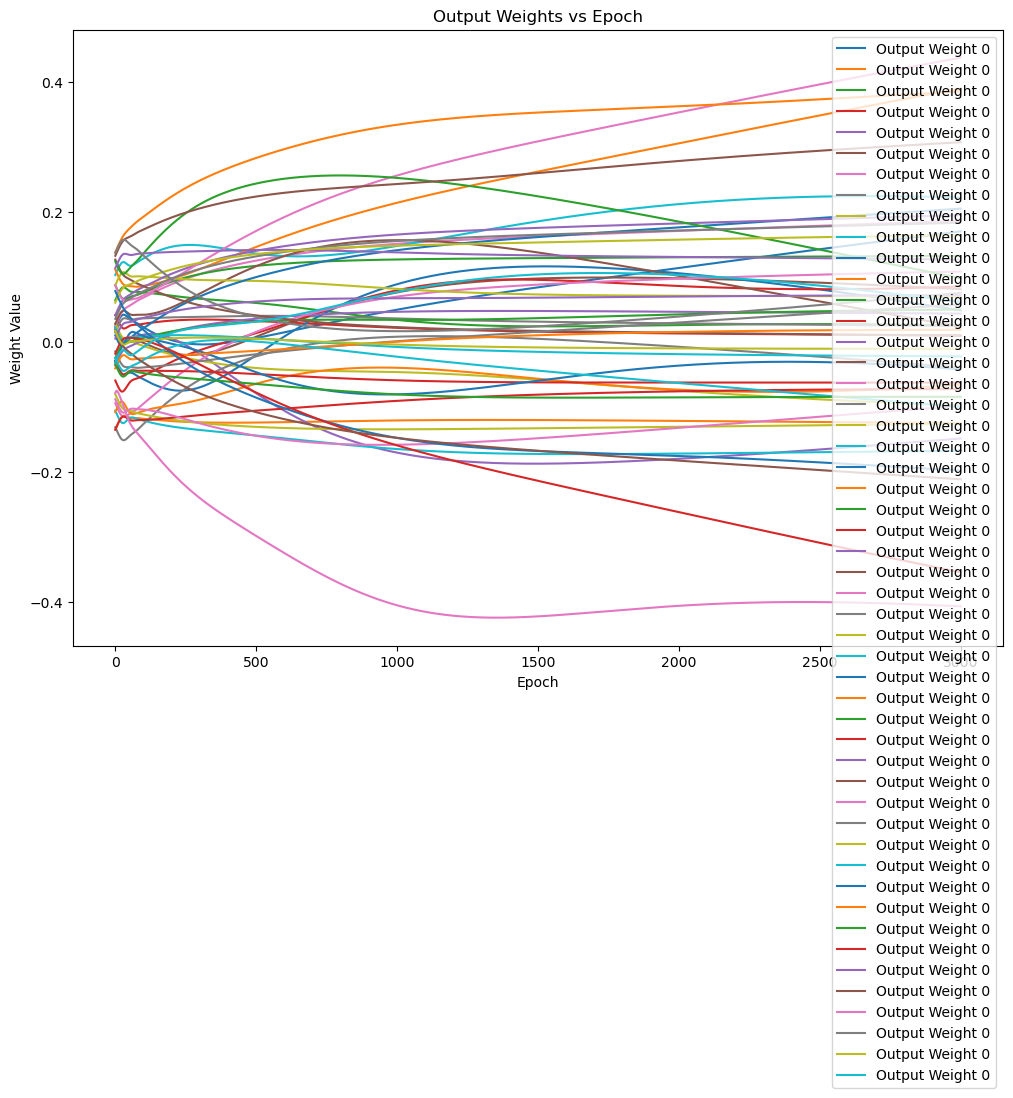

In [2]:
# Plot output weights vs epoch
output_weights = np.array(output_weights)
plt.figure(figsize=(12, 8))
num_outputs = output_weights.shape[1]
for i in range(num_outputs):
    plt.plot(epochs, output_weights[:, i], label=f"Output Weight {i}")
plt.title("Output Weights vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Weight Value")
plt.legend()
plt.show()

In [3]:
import matplotlib.pyplot as plt
import torch
import torch.autograd as autograd



def plot_profiles(total, title, xlab, ylab, ylim=None):
    plt.figure(figsize=(6, 4))
    plt.grid()

    x_pde = torch.linspace(0, 5, 1000).view(-1, 1)

    for i, tensor in enumerate(total):
        plt.plot(x_pde, tensor.detach().numpy(), label=f'beta = 1')

    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.legend()
    if ylim is not None:
        plt.ylim((0, ylim))

    plt.savefig(f"{title.replace(' ', '_')}.png")
    plt.show()

def compute_profiles(models, x_pde, profile_function):
    profiles = []

    for i in range(len(models)):
        a = models[i]
        y = a(x_pde)
        profiles.append(profile_function(y, x_pde))

    return profiles



In [4]:
def velocity_prof(model_input, x):
    beta = 1
    m = beta / (2 - beta)
    u_U = torch.autograd.grad(model_input, x, grad_outputs=torch.ones_like(predictions))[0]
    return u_U

def shear_stress_profile(model_input, x):
    beta = 1
    m = beta / (2 - beta)
    m = torch.tensor(m)
    u = x**m
    
    
    d1 = torch.autograd.grad(model_input, x, grad_outputs=torch.ones_like(predictions), create_graph=True)[0]
    d2 = torch.autograd.grad(d1, x, grad_outputs=torch.ones_like(predictions), create_graph=True)[0]
    
    a = torch.sqrt((m+1)/2)
    b = u
    c = d2[0]
    SS = a * b * c
    return SS


def displacement_thickness_profile(model_input, x):
    with torch.enable_grad():
        d1 = autograd.grad(model_input, x, grad_outputs=torch.ones_like(model_input), create_graph=True)[0]
    beta = 1
    m = beta / (2 - beta)
    u = x**m

    c = torch.sqrt(2 / ((m + 1) * u))
    d = x**(1/2)

    f2 = 1 - d1
    integral = torch.trapz(f2, x)
    DT = c * d * integral

    return DT

def momentum_thickness_profile(model_input, x):
    d1 = torch.autograd.grad(model_input, x, grad_outputs=torch.ones_like(model_input), create_graph=True)[0]
    beta = 1
    m = beta / (2 - beta)
    u = x**m
    
    c = torch.sqrt(2/((m+1)*u))
    d = x**(1/2)
    f2 = (1 - d1)*d1
    integral = torch.trapz(f2, x)
    MT = c * d * integral
    return MT

def shape_factor(model_input, x):
    beta = 1
    m = beta / (2 - beta)
    d1 = torch.autograd.grad(model_input, x, grad_outputs=torch.ones_like(model_input), create_graph=True)[0]
    f1 = 1 - d1
    f2 = (1 - d1)*d1
    
    integral1 = torch.trapz(f1.squeeze(), x.squeeze())  
    integral2 = torch.trapz(f2.squeeze(), x.squeeze())  
    
    SF = integral1 / integral2
    return SF

def skin_friction(model_input, x):
    beta = 1
    d1 = torch.autograd.grad(model_input, x, grad_outputs=torch.ones_like(predictions), create_graph=True)[0]
    d2 = torch.autograd.grad(d1, x, grad_outputs=torch.ones_like(predictions), create_graph=True)[0]
    
    m = beta / (2 - beta)
    u = x**m
            
    num = 2 * d2
    c = 1/(x**(1/2))
    den = torch.sqrt((m+1)/(2*u))
    SKF = num * c * den
    return SKF


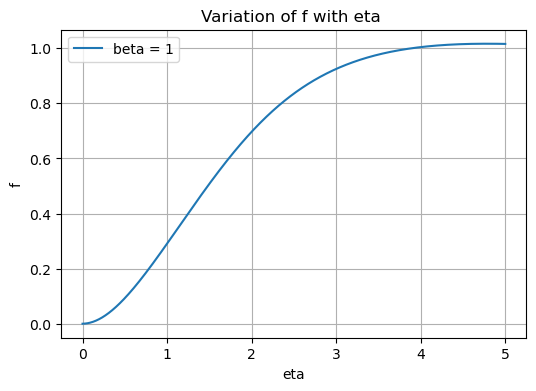

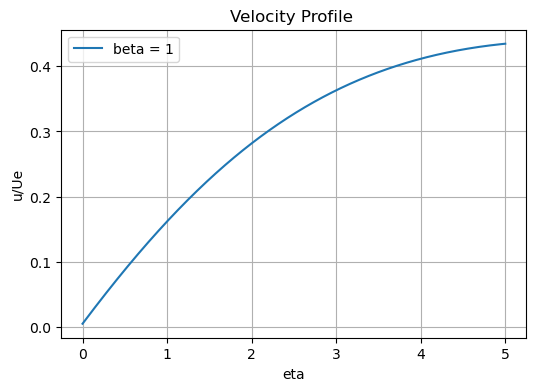

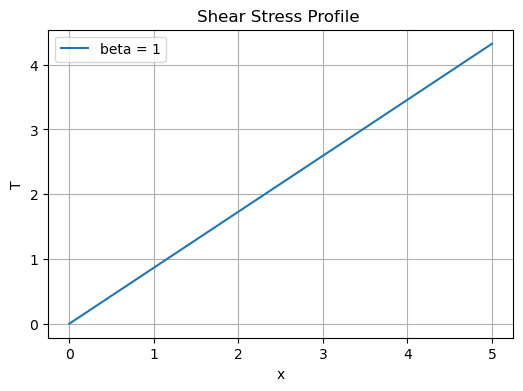

[tensor(5.8115, grad_fn=<DivBackward0>)]


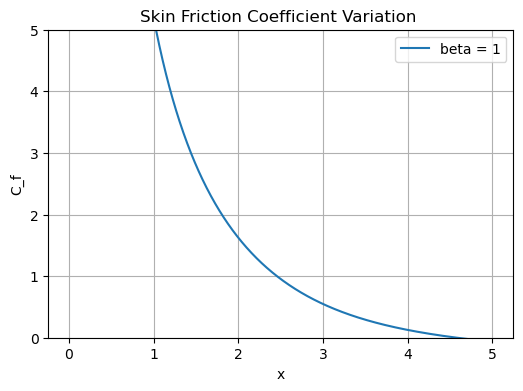

In [5]:

x_pde = torch.linspace(0, 5, 1000).view(-1, 1)
# Compute and plot various profiles
total = []

for model in models:
    with torch.no_grad():
        predictions = model(x_pde)

    z = torch.linspace(0, 5, 1000).view(-1, 1)
    with torch.no_grad():
        outputs = model(z)
        total.append(outputs)

        
        
plot_profiles(total, 'Variation of f with eta ', 'eta', 'f')

x_pde = torch.linspace(0, 1, 1000).view(-1, 1).requires_grad_()
u_Us = compute_profiles(models, x_pde, velocity_prof)
plot_profiles(u_Us, 'Velocity Profile ', 'eta', 'u/Ue')

x_pde = torch.linspace(0, 5, 1000).view(-1, 1).requires_grad_()
SSs = compute_profiles(models, x_pde, shear_stress_profile)
plot_profiles(SSs, 'Shear Stress Profile ', 'x', 'Τ')

x_pde = torch.linspace(0, 5, 1000).view(-1, 1).requires_grad_()
SFs = compute_profiles(models, x_pde,shape_factor)
print(SFs)

x_pde = torch.linspace(0, 1.25, 1000).view(-1, 1).requires_grad_()
SKFs = compute_profiles(models, x_pde,skin_friction)
plot_profiles(SKFs, 'Skin Friction Coefficient Variation ', 'x', 'C_f', ylim=5)
